In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as tiffio
from pathlib import Path
import glob
from scipy.optimize import curve_fit
import time

In [2]:
#copying path from windows file explorer gives backslashes.. this is accounted for in the "replace" line
#the r before a windows path is essential.. It reads \ in raw formatting and makes life easier
#do NOT add a \ at the end of the path.. results in End of Line error. / is added to the complete file path while reading images
#prints corrected input folder path and displays number of .tif files in folder
read_path = r"/Volumes/GoogleDrive/My Drive/Debaditya Chatterjee/Data/ECM/20191112_ECM_PtCuNiP_246C_AmC_10nm_30um_obj/twice_crop_align_wrt_first"
#change \ to / in Windows file paths
read_path = read_path.replace("\\", "/")

print(read_path)
print(len(glob.glob(read_path+"/*.tif")))

/Volumes/GoogleDrive/My Drive/Debaditya Chatterjee/Data/ECM/20191112_ECM_PtCuNiP_246C_AmC_10nm_30um_obj/twice_crop_align_wrt_first
4000


(631, 861)


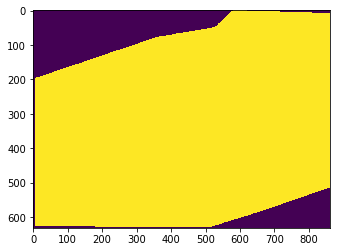

In [3]:
#loads ROI mask and displays it
#while loading mask it is converted to bool data type as it is imported into float by default. bool makes it easy to delete
#non-ROI data later

def load_mask(ROI_text_file):
    mask = np.loadtxt(ROI_text_file, unpack = True).astype(np.bool)
    return mask

ROI = load_mask("ROI_w_C_python.itx")
print(ROI.shape)
plt.imshow(ROI)
#plt.colorbar() #colorbar does not work for bool datatype
plt.show()

In [4]:
#loads pixel intensity time series from all images and saves it as a datacube (x,y,t)

#function to load single .tif into memory
def load_tif(filename):
    loaded_tif = tiffio.imread(filename, plugin='tifffile')
    return loaded_tif

#function to load pixel intensity time series from all images in given folder and return datacube (x,y,t)
def data_from_tiff_folder(folderpath, verbose = True):
    file_names = sorted(glob.glob(folderpath+"/*.tif")) #list of tif files in folderpath directory
    
    (x,y) = load_tif(file_names[0]).shape
    t = len(file_names) #t here is number of frames
    
    if verbose:
        print(f"Loading {t} tifs from {folderpath}")
        
        
    #int16 takes 4 times less space than float. Do not use uint16 as 'u' saturates pixels with negative intensity that arise
    #from drift correction
    data = np.zeros((x,y,t), dtype = np.int16) 
    
    for i, fn in enumerate(file_names):
        data[:,:,i] = load_tif(fn)
        if verbose and i%1000 == 0:
            print(i)
            
    if verbose:
        print("Finished loading data")
        
    return data

In [5]:
data = data_from_tiff_folder(read_path)

Loading 4000 tifs from /Volumes/GoogleDrive/My Drive/Debaditya Chatterjee/Data/ECM/20191112_ECM_PtCuNiP_246C_AmC_10nm_30um_obj/twice_crop_align_wrt_first
0
1000
2000
3000
Finished loading data


In [6]:
#after loading data we need to generate t_resampled values and calculate g2_rs
#the following functions calculate t_rs, and g2 for given intensity array

#t_rs calculating function that runs from dt to (expt time - dt), e.g. from 0.1 to 399.9
def t_resampled(t_size,dt,t_rs_size):
    t_rs = np.zeros(t_rs_size, dtype = np.float)
    
    for i in range(t_rs_size):
        t_rs[i] = np.power(10, np.log10(dt) + np.log10(t_size - 1)*i/(t_rs_size - 1))
        
    return t_rs

#calculates g2 for given intensity array and integer lag
def calc_g2_lag(I_t,lag):
    I_size = len(I_t)
    g2_lag = np.mean(I_t[lag:]*I_t[0:(I_size - lag)])/(np.mean(I_t[lag:])*np.mean(I_t[0:(I_size - lag)]))
    return g2_lag

#calculate g2 for lag = floor(t_rs/dt) and lag = ceil(t_rs/dt) and interpolate the value of g2(t_rs).. this is done implicitly
#in Igor
#write a function that will accept Intensity array and fractional t. Return interpolated g2 value. Uses g2_lag function to do
#the actual g2 calculation
#an addtional subtlety one needs to remember is that the multiplication factor in g2 interpolation is (t/dt - lag_low) and not
#(t - lag_low*dt) as the former falls in [0,1] while the latter falls in [0,dt]. We need a multiplication factor
#independent of dt.
def g2_t(I_t,t,dt):
    lag_low = int(np.floor(t/dt))
    lag_high = int(np.ceil (t/dt))
    
    g2_low = calc_g2_lag(I_t,lag_low)
    g2_high = calc_g2_lag(I_t,lag_high)
    #g2_t = g2_low + (g2_high - g2_low)*(t - lag_low*dt)
    g2_t = g2_low + (g2_high - g2_low)*(t/dt - lag_low)
    
    #print(lag_low,lag_high,g2_low,g2_high,g2_t)
    
    return g2_t

#after calculation of g2_t need to perform curve fitting to extract fitting parameters (A,tau,beta) and estimate fitting error
#from the magnitude of the normalized standard deviations obtained from pcov
def KWW_curve(t, A, tau, beta):
    return 1 + A*np.exp(-2*np.power((t/tau),beta))

#the curve fitting function accepts I_t,dt,M(size of t_rs array) and performs curvefitting
#returns fitting parameters and combined fitting error
def KWW_fitting(I_t,dt,M):
    
    size = len(I_t)
    
    t_rs = t_resampled(size,dt,M)
    g2_rs = calc_g2_rs(I_t,t_rs,dt)
    
    popt, pcov = curve_fit(KWW_curve, t_rs, g2_rs, p0 = [g2_rs[0]-1,200*dt,1])
    perr = np.sqrt(np.diag(pcov))
    error = np.sqrt((perr/popt).dot(perr/popt))
    
    return popt,error

In [7]:
#function to calculate datacube containing g2_rs[x][y] = g2(t) for every pixel
#takes datacube I(x,y,t), mask ROI(x,y), dt, t and returns g2(x,y,t)
#can be used for any t array containing time series (actual or resammpled). However, calculating g2 for the fully sampled t
#series can be time consuming and unnecessary

def g2_data(data,mask,dt,t):
    (x,y) = mask.shape
    z = t.size
    
    g2_data = np.zeros((x,y,z), dtype = np.float)
    g2_data[~mask,:] = np.nan
    
    print(mask.shape)
    
    #loop to extract I_t from each pixel and pass it through g2_t function. It is essential to cast the intensity array (that is
    #in uint16 datatype) to float before passing it to g2 the calculating function
    for i in range(x):
        for j in range(y):
            if (((i*y + j)/(x*y)*100)%10 == 0):
                print("Progress%=",((i*y + j)/(x*y)*100))
            if (mask[i][j]):
                #print(i,j)
                for k,t_k in enumerate(t):
                    g2_data[i][j][k] = g2_t(data[i][j].astype('float'),t_k,dt)
                    
    return g2_data

#function to calculate fitting parameters and fitting error for every pixel

In [9]:
start = time.time()

t_rs = t_resampled(4000,0.25,200)

g2_rs = g2_data(data, ROI, 0.25, t_rs)

end = time.time()
print(f"Duration = {end - start}")

(631, 861)
Progress%= 0.0
Duration = 5461.2105848789215


In [12]:
g2_rs.shape

(390, 880, 200)

In [11]:
t_rs

array([1.00000000e-01, 1.04255808e-01, 1.08692735e-01, 1.13318489e-01,
       1.18141106e-01, 1.23168965e-01, 1.28410799e-01, 1.33875717e-01,
       1.39573210e-01, 1.45513178e-01, 1.51705939e-01, 1.58162252e-01,
       1.64893334e-01, 1.71910878e-01, 1.79227075e-01, 1.86854635e-01,
       1.94806809e-01, 2.03097413e-01, 2.11740849e-01, 2.20752133e-01,
       2.30146919e-01, 2.39941530e-01, 2.50152981e-01, 2.60799012e-01,
       2.71898117e-01, 2.83469578e-01, 2.95533499e-01, 3.08110837e-01,
       3.21223443e-01, 3.34894096e-01, 3.49146545e-01, 3.64005552e-01,
       3.79496929e-01, 3.95647590e-01, 4.12485591e-01, 4.30040186e-01,
       4.48341870e-01, 4.67422439e-01, 4.87315041e-01, 5.08054233e-01,
       5.29676045e-01, 5.52218041e-01, 5.75719380e-01, 6.00220891e-01,
       6.25765140e-01, 6.52396502e-01, 6.80161245e-01, 7.09107601e-01,
       7.39285859e-01, 7.70748445e-01, 8.03550019e-01, 8.37747564e-01,
       8.73400492e-01, 9.10570740e-01, 9.49322882e-01, 9.89724240e-01,
      

[]

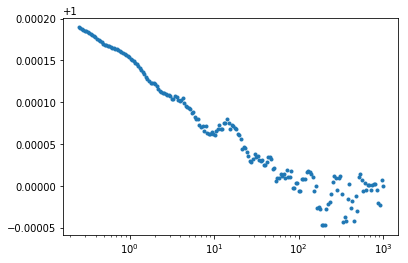

In [14]:
plt.plot(t_rs,g2_rs[350,200],'.')
plt.semilogx()

In [21]:
#write function to normalize full 3D g2(x,y,t) to (g2 - 1)/A
def normalize_g2(g2):
    x,y,z = g2.shape
    
    g2_norm = np.zeros(g2.shape, dtype = np.float)
    
    for i in range(x):
        for j in range(y):
            if (((i*y + j)/(x*y)*100)%10 == 0):
                print("Progress%=",((i*y + j)/(x*y)*100))
            if g2[i][j][0]:
                g2_norm[i][j] = (g2[i][j] - 1)/(g2[i][j][0] - 1)
            else:
                g2_norm[i][j][:] = np.nan
                
    return g2_norm

In [22]:
g2_rs_norm = normalize_g2(g2_rs)

Progress%= 0.0
Progress%= 10.0
Progress%= 20.0
Progress%= 30.0
Progress%= 40.0
Progress%= 50.0
Progress%= 60.0
Progress%= 70.0
Progress%= 80.0
Progress%= 90.0


[]

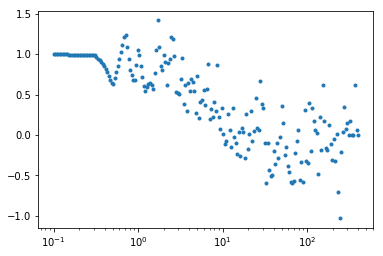

In [23]:
plt.plot(t_rs, g2_rs_norm[370], '.')
plt.semilogx()

In [24]:
np.save("g2_rs_norm", g2_rs_norm) #saves binary file with normalized g2 values

In [10]:
np.save("g2_rs",g2_rs) #saves binary file with g2 values